Pandapower server listening on tcp://127.0.0.1:5556
Iteration 0, Received request: GET_POWER
Updating load to 0.303 MW
Computed total load (p_mw): 0.303
Iteration 1, Received request: GET_POWER
Updating load to 0.339 MW
Computed total load (p_mw): 0.339
Iteration 2, Received request: GET_POWER
Updating load to 0.348 MW
Computed total load (p_mw): 0.348
Iteration 3, Received request: GET_POWER
Updating load to 0.394 MW
Computed total load (p_mw): 0.394
Iteration 4, Received request: GET_POWER
Updating load to 0.432 MW
Computed total load (p_mw): 0.432
Iteration 5, Received request: GET_POWER
Updating load to 0.45 MW
Computed total load (p_mw): 0.45
Iteration 6, Received request: GET_POWER
Updating load to 0.419 MW
Computed total load (p_mw): 0.419
Iteration 7, Received request: GET_POWER
Updating load to 0.402 MW
Computed total load (p_mw): 0.402
Iteration 8, Received request: GET_POWER
Updating load to 0.391 MW
Computed total load (p_mw): 0.391
Iteration 9, Received request: GET_POWER


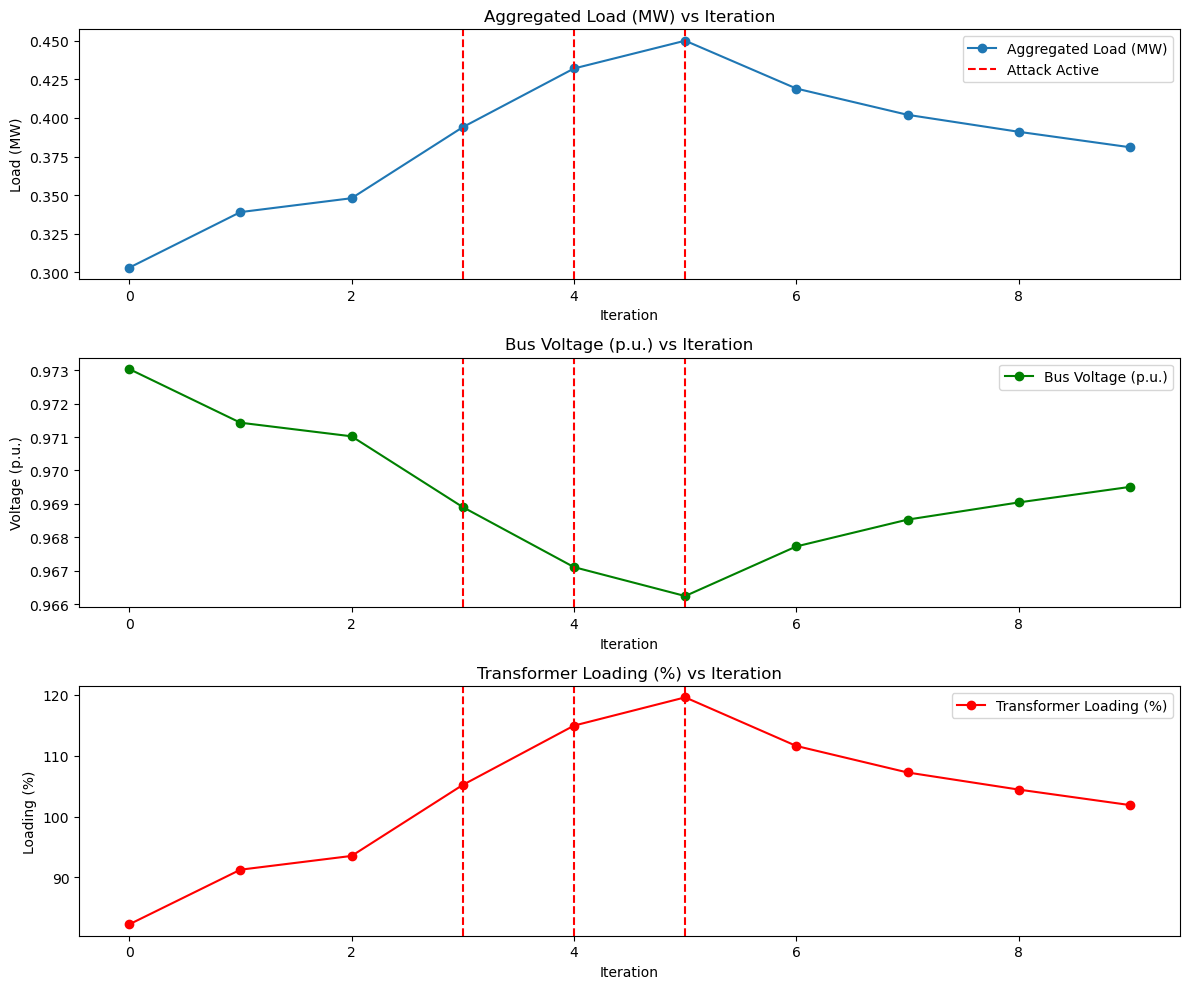

In [2]:
# MITM
import zmq
import pandapower as pp
import random
import math
import time
import csv
import matplotlib.pyplot as plt

def build_network():
    net = pp.create_empty_network()
    bus_hv = pp.create_bus(net, vn_kv=20., name="High Voltage Bus")
    bus_lv = pp.create_bus(net, vn_kv=0.4, name="Low Voltage Bus")
    pp.create_ext_grid(net, bus_hv, vm_pu=1.0, name="Grid Connection")
    pp.create_transformer(net, bus_hv, bus_lv, std_type="0.4 MVA 20/0.4 kV", name="Transformer")
    pp.create_load(net, bus_lv, p_mw=0.3, q_mvar=0.1, name="Load")
    return net

def run_server(iterations=50, csv_filename='pandapower_stats.csv'):
    context = zmq.Context()
    socket = context.socket(zmq.REP)
    socket.bind("tcp://127.0.0.1:5556")
    print("Pandapower server listening on tcp://127.0.0.1:5556")
    
    net = build_network()
    
    # Open CSV file for logging simulation metrics
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['iteration', 'timestamp', 'load_mw', 'bus_voltage', 'transformer_loading', 'attack_active']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        iteration = 0
        while iteration < iterations:
            try:
                request = socket.recv_string()
                print(f"Iteration {iteration}, Received request: {request}")
                if request == "GET_POWER":
                    # Simulate diurnal load variation using a sine function
                    base_load = 0.3
                    amplitude = 0.1  # amplitude of variation
                    period = 24      # 24 iterations represent a full cycle (diurnal pattern)
                    sine_variation = amplitude * math.sin(2 * math.pi * iteration / period)
                    noise = random.uniform(-0.02, 0.02)  # small random noise
                    new_load = round(base_load + sine_variation + noise, 3)
                    
                    # Optionally, simulate an effect of a cyber attack on the load reading.
                    # For instance, if an attack is active during iterations 3-5, you could inject an anomaly:
                    if iteration in [3, 4, 5]:
                        attack_active = 1
                        # Optionally modify new_load to simulate attack-induced disturbance:
                        new_load = round(new_load * 1.1, 3)  # e.g., 10% increase during attack
                    else:
                        attack_active = 0

                    print(f"Updating load to {new_load} MW")
                    net.load.at[0, 'p_mw'] = new_load
                    
                    # Run power flow calculation
                    pp.runpp(net)
                    total_load = net.res_load["p_mw"].sum()
                    
                    # Extract additional metrics:
                    # Assume bus_lv is at index 1 (bus_hv at index 0)
                    bus_voltage = net.res_bus.vm_pu.iloc[1] if len(net.res_bus) > 1 else 1.0
                    # Assume the first transformer
                    transformer_loading = net.res_trafo.loading_percent.iloc[0] if len(net.res_trafo) > 0 else 0.0
                    
                    # Log metrics to CSV with a timestamp and attack flag
                    timestamp = time.time()
                    writer.writerow({
                        'iteration': iteration,
                        'timestamp': timestamp,
                        'load_mw': total_load,
                        'bus_voltage': bus_voltage,
                        'transformer_loading': transformer_loading,
                        'attack_active': attack_active
                    })
                    csvfile.flush()
                    
                    reply = str(total_load)
                    print(f"Computed total load (p_mw): {reply}")
                else:
                    reply = "unknown command"
                    print("Received unknown command.")
                socket.send_string(reply)
                iteration += 1
            except Exception as e:
                print(f"Error occurred: {e}")
                socket.send_string("error")
    
    socket.close()
    context.term()

def analyze_data(csv_filename='pandapower_stats.csv'):
    # Read CSV data and generate plots using matplotlib
    iterations = []
    load_values = []
    bus_voltages = []
    transformer_loadings = []
    attack_iterations = []  # store iterations where attack_active is 1
    
    with open(csv_filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            iter_val = int(row['iteration'])
            iterations.append(iter_val)
            load_values.append(float(row['load_mw']))
            bus_voltages.append(float(row['bus_voltage']))
            transformer_loadings.append(float(row['transformer_loading']))
            if int(row['attack_active']) == 1:
                attack_iterations.append(iter_val)
    
    plt.figure(figsize=(12, 10))
    
    # Plot aggregated load
    plt.subplot(3, 1, 1)
    plt.plot(iterations, load_values, marker='o', label='Aggregated Load (MW)')
    for atk in attack_iterations:
        plt.axvline(x=atk, color='red', linestyle='--', label='Attack Active' if atk == attack_iterations[0] else "")
    plt.title('Aggregated Load (MW) vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Load (MW)')
    plt.legend()
    
    # Plot bus voltage
    plt.subplot(3, 1, 2)
    plt.plot(iterations, bus_voltages, marker='o', color='green', label='Bus Voltage (p.u.)')
    for atk in attack_iterations:
        plt.axvline(x=atk, color='red', linestyle='--')
    plt.title('Bus Voltage (p.u.) vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Voltage (p.u.)')
    plt.legend()
    
    # Plot transformer loading
    plt.subplot(3, 1, 3)
    plt.plot(iterations, transformer_loadings, marker='o', color='red', label='Transformer Loading (%)')
    for atk in attack_iterations:
        plt.axvline(x=atk, color='red', linestyle='--')
    plt.title('Transformer Loading (%) vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loading (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run the pandapower server for a fixed number of iterations
    run_server(iterations=10, csv_filename='pandapower_stats.csv')
    # Once done, analyze and visualize the collected data
    analyze_data(csv_filename='pandapower_stats.csv')


Pandapower server listening on ports 5556 (GET_POWER) and 5557 (SET_DER_OUTPUT)
Iteration 0, Received request on GET_POWER: GET_POWER
Updating load to 0.287 MW
Computed total load (p_mw): 0.287
Received request on SET_DER_OUTPUT: SET_DER_OUTPUT 0.2002
Updating DER output to 0.2002 MW
Iteration 1, Received request on GET_POWER: GET_POWER
Updating load to 0.307 MW
Computed total load (p_mw): 0.307
Iteration 2, Received request on GET_POWER: GET_POWER
Updating load to 0.365 MW
Computed total load (p_mw): 0.365
Iteration 3, Received request on GET_POWER: GET_POWER
Updating load to 0.377 MW
Computed total load (p_mw): 0.377
Iteration 4, Received request on GET_POWER: GET_POWER
Updating load to 0.381 MW
Computed total load (p_mw): 0.381
Iteration 5, Received request on GET_POWER: GET_POWER
Updating load to 0.399 MW
Computed total load (p_mw): 0.399
Iteration 6, Received request on GET_POWER: GET_POWER
Updating load to 0.402 MW
Computed total load (p_mw): 0.402
Iteration 7, Received request o

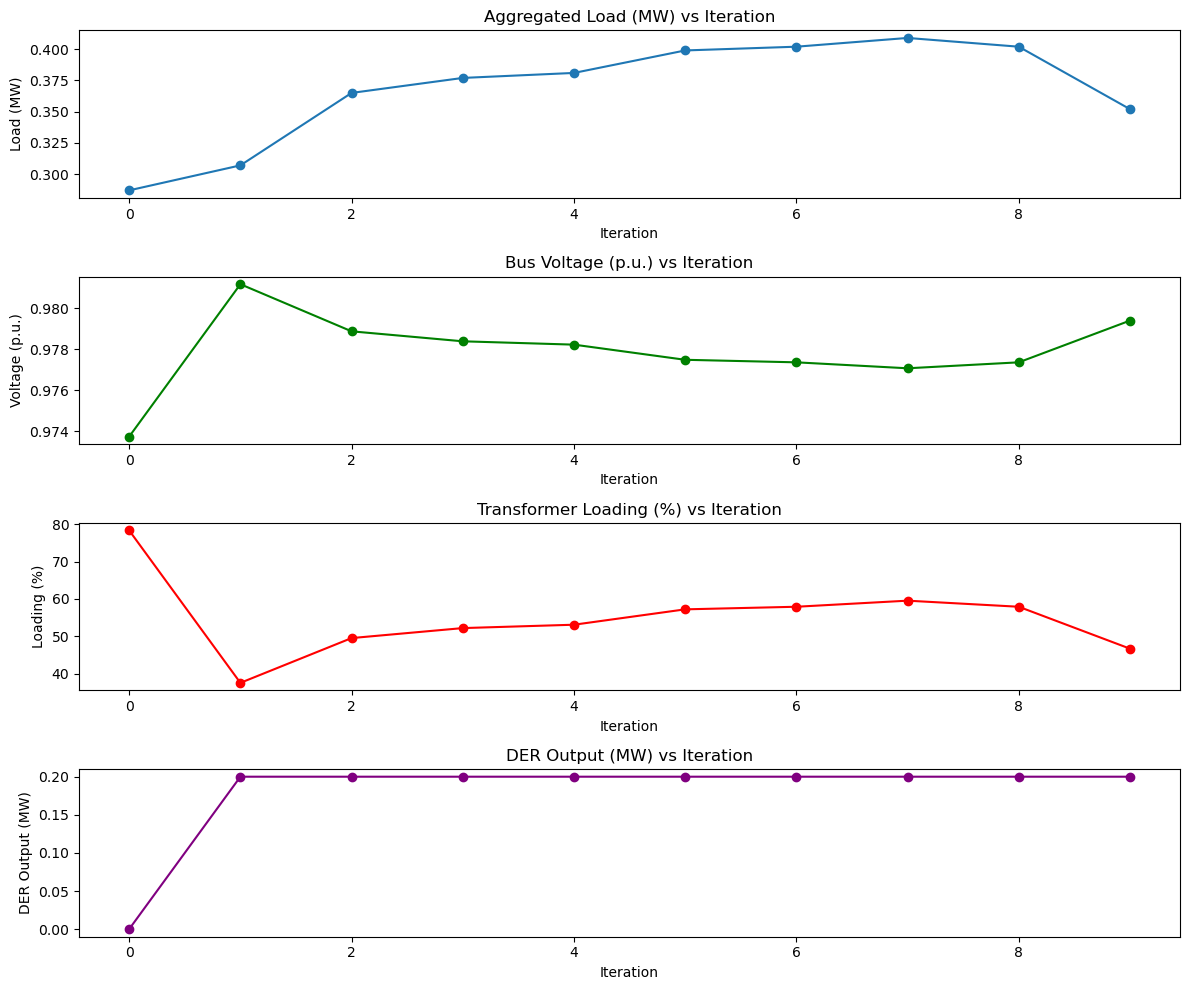

In [4]:
#Normal Simualtion
import zmq
import pandapower as pp
import random
import math
import time
import csv
import matplotlib.pyplot as plt

def build_network():
    net = pp.create_empty_network()
    bus_hv = pp.create_bus(net, vn_kv=20., name="High Voltage Bus")
    bus_lv = pp.create_bus(net, vn_kv=0.4, name="Low Voltage Bus")
    pp.create_ext_grid(net, bus_hv, vm_pu=1.0, name="Grid Connection")
    pp.create_transformer(net, bus_hv, bus_lv, std_type="0.4 MVA 20/0.4 kV", name="Transformer")
    pp.create_load(net, bus_lv, p_mw=0.3, q_mvar=0.1, name="Load")
    # Create a DER (static generator) with initial 0 output.
    pp.create_sgen(net, bus_lv, p_mw=0.0, q_mvar=0.0, name="DER")
    return net

def run_server(iterations=50, csv_filename='pandapower_stats.csv'):
    context = zmq.Context()
    # Socket for GET_POWER requests (port 5556)
    get_power_socket = context.socket(zmq.REP)
    get_power_socket.bind("tcp://*:5556")
    # Socket for SET_DER_OUTPUT commands (port 5557)
    set_der_socket = context.socket(zmq.REP)
    set_der_socket.bind("tcp://*:5557")
    
    # Use a poller to monitor both sockets.
    poller = zmq.Poller()
    poller.register(get_power_socket, zmq.POLLIN)
    poller.register(set_der_socket, zmq.POLLIN)
    
    print("Pandapower server listening on ports 5556 (GET_POWER) and 5557 (SET_DER_OUTPUT)")
    
    net = build_network()
    
    # Open CSV file for logging simulation metrics (for GET_POWER responses)
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['iteration', 'timestamp', 'load_mw', 'bus_voltage', 'transformer_loading', 'der_output']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        iteration = 0
        while iteration < iterations:
            socks = dict(poller.poll(1000))
            # Process GET_POWER requests
            if get_power_socket in socks and socks[get_power_socket] == zmq.POLLIN:
                request = get_power_socket.recv_string()
                print(f"Iteration {iteration}, Received request on GET_POWER: {request}")
                if request == "GET_POWER":
                    # Simulate diurnal load variation using a sine function
                    base_load = 0.3
                    amplitude = 0.1
                    period = 24
                    sine_variation = amplitude * math.sin(2 * math.pi * iteration / period)
                    noise = random.uniform(-0.02, 0.02)
                    new_load = round(base_load + sine_variation + noise, 3)
                    print(f"Updating load to {new_load} MW")
                    net.load.at[0, 'p_mw'] = new_load
                    
                    # Run power flow calculation
                    pp.runpp(net)
                    total_load = net.res_load["p_mw"].sum()
                    
                    # Extract additional metrics
                    bus_voltage = net.res_bus.vm_pu.iloc[1] if len(net.res_bus) > 1 else 1.0
                    transformer_loading = net.res_trafo.loading_percent.iloc[0] if len(net.res_trafo) > 0 else 0.0
                    der_output = net.sgen.at[0, 'p_mw']
                    
                    timestamp = time.time()
                    writer.writerow({
                        'iteration': iteration,
                        'timestamp': timestamp,
                        'load_mw': total_load,
                        'bus_voltage': bus_voltage,
                        'transformer_loading': transformer_loading,
                        'der_output': der_output
                    })
                    csvfile.flush()
                    
                    reply = str(total_load)
                    print(f"Computed total load (p_mw): {reply}")
                else:
                    reply = "unknown command"
                    print("Received unknown command on GET_POWER.")
                get_power_socket.send_string(reply)
                iteration += 1  # increment iteration only on GET_POWER requests
            
            # Process SET_DER_OUTPUT commands
            if set_der_socket in socks and socks[set_der_socket] == zmq.POLLIN:
                request = set_der_socket.recv_string()
                print(f"Received request on SET_DER_OUTPUT: {request}")
                parts = request.split()
                if len(parts) == 2 and parts[0] == "SET_DER_OUTPUT":
                    try:
                        new_der_value = float(parts[1])
                        print(f"Updating DER output to {new_der_value} MW")
                        net.sgen.at[0, 'p_mw'] = new_der_value
                        pp.runpp(net)
                        reply = f"DER output set to {new_der_value} MW"
                    except Exception as e:
                        reply = f"Error: {str(e)}"
                else:
                    reply = "unknown command"
                set_der_socket.send_string(reply)
    
    get_power_socket.close()
    set_der_socket.close()
    context.term()

def analyze_data(csv_filename='pandapower_stats.csv'):
    iterations = []
    load_values = []
    bus_voltages = []
    transformer_loadings = []
    der_outputs = []
    
    with open(csv_filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            iterations.append(int(row['iteration']))
            load_values.append(float(row['load_mw']))
            bus_voltages.append(float(row['bus_voltage']))
            transformer_loadings.append(float(row['transformer_loading']))
            der_outputs.append(float(row['der_output']))
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(4, 1, 1)
    plt.plot(iterations, load_values, marker='o')
    plt.title('Aggregated Load (MW) vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Load (MW)')
    
    plt.subplot(4, 1, 2)
    plt.plot(iterations, bus_voltages, marker='o', color='green')
    plt.title('Bus Voltage (p.u.) vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Voltage (p.u.)')
    
    plt.subplot(4, 1, 3)
    plt.plot(iterations, transformer_loadings, marker='o', color='red')
    plt.title('Transformer Loading (%) vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loading (%)')
    
    plt.subplot(4, 1, 4)
    plt.plot(iterations, der_outputs, marker='o', color='purple')
    plt.title('DER Output (MW) vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('DER Output (MW)')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_server(iterations=10, csv_filename='pandapower_stats.csv')
    analyze_data(csv_filename='pandapower_stats.csv')
